In [1]:
%config Completer.use_jedi = False

import sys
sys.path.append('../../ACORE-LFI/')
sys.path.append('../../ACORE-LFI/acore/')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from toy_gauss import generate_data, plot_data
from models.muon_features import MuonFeatures
from acore_ada import ACORE

### - a = b = 1 --> uniform

In [5]:
data = generate_data(sample_size=10000, beta_a=1, beta_b=1, lower_theta=0, higher_theta=100, scale=5, split=False)
data.head()

,theta,x1,x2
0,84.399733,24.180055,-45.904904
1,9.975710,12.742785,-7.836749
2,37.608843,27.666430,-11.285565
3,30.577573,20.868927,-7.416271
4,51.311296,21.593246,-19.135942


# Construct confidence intervals for $\theta$ with ACORE

### MLP

In [4]:
model = MuonFeatures(data=data, 
                     t0_grid_granularity=100, 
                     true_param_low=0, 
                     true_param_high=100, 
                     param_dims = 1,
                     observed_dims=2, 
                     observed_sample_fraction=0.1,
                     reference_g='marginal',
                     param_column=0, 
                     debug=True)

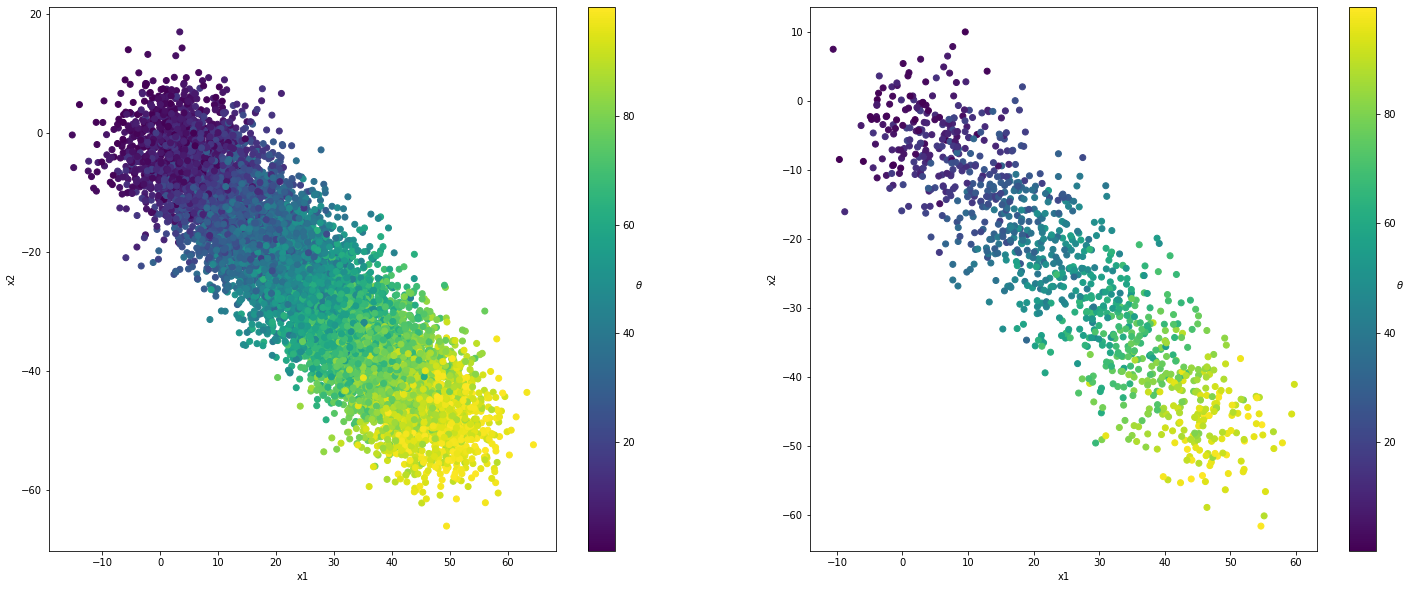

In [6]:
plot_data(data=model.train_set, test_set=np.hstack((model.obs_param.reshape(-1, 1), model.obs_x)), fig_size=(25, 10))

In [5]:
acore = ACORE(model=model, 
              b=2000, 
              b_prime=5000, 
              alpha=0.05, 
              classifier_or='MLP', 
              classifier_qr='xgb_d3_n100',   
              sample_size_obs=1, 
              debug=True)

In [6]:
acore.model.train_set_left.shape, acore.model.train_set.shape, acore.model.obs_x.shape, acore.model.obs_param.shape

((9000, 3), (9000, 3), (1000, 2), (1000,))

In [7]:
acore.confidence_band()

----- MLP Trained


Calculate Odds: 100%|██████████| 100000/100000 [03:27<00:00, 480.92it/s]

----- Training Quantile Regression Algorithm


----- Creating Confidence Band


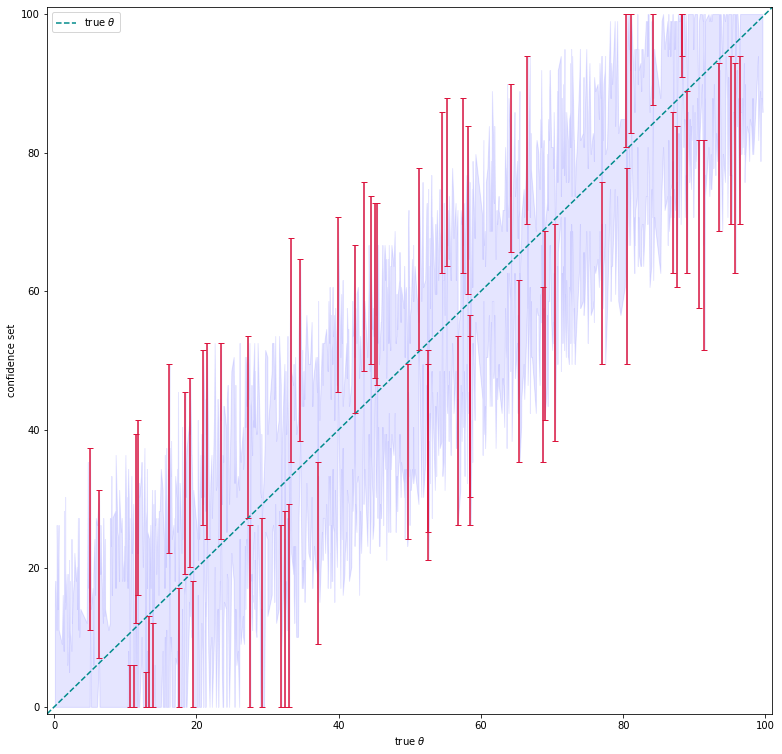

In [8]:
df = acore.plot_confidence_band(return_df=True)

In [9]:
df.loc[df.covered == False,:].shape

(65, 7)

### QDA

In [6]:
model = MuonFeatures(data=data, 
                     t0_grid_granularity=100, 
                     true_param_low=0, 
                     true_param_high=100, 
                     param_dims = 1,
                     observed_dims=2, 
                     observed_sample_fraction=0.02,
                     reference_g='marginal',
                     param_column=0, 
                     debug=True)

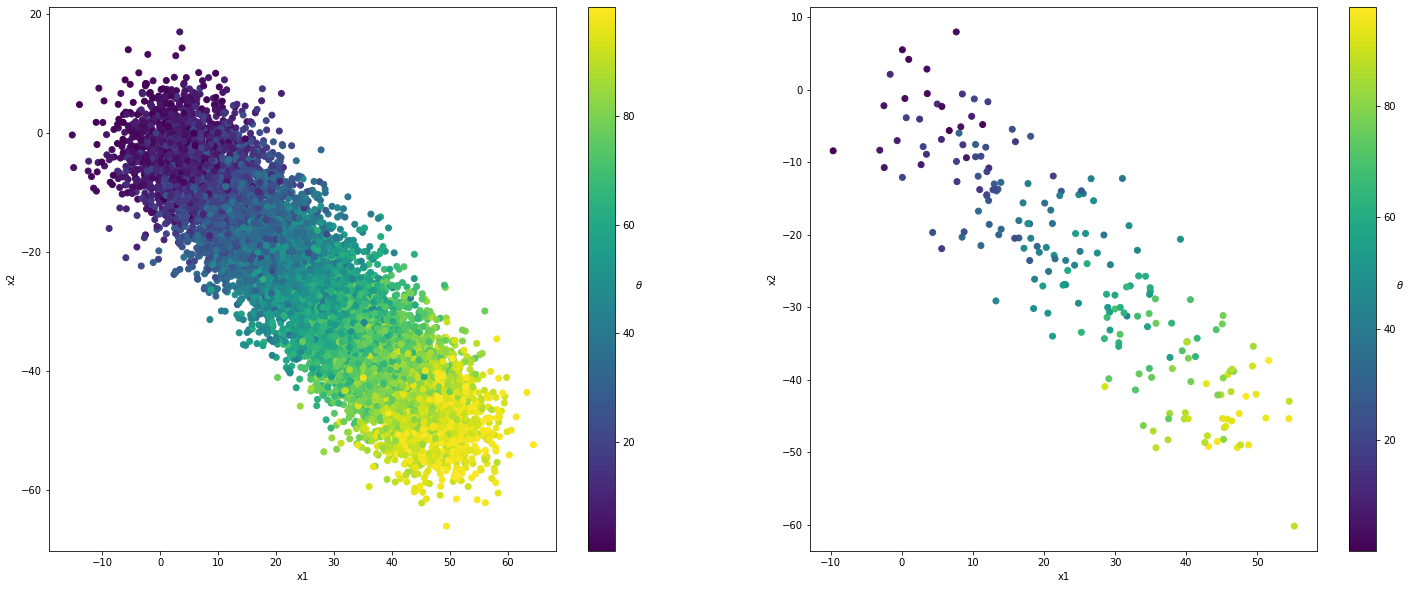

In [7]:
plot_data(data=model.train_set, test_set=np.hstack((model.obs_param.reshape(-1, 1), model.obs_x)), fig_size=(25, 10))

In [8]:
acore = ACORE(model=model, 
              b=2000, 
              b_prime=5000, 
              alpha=0.05, 
              classifier_or='QDA', 
              classifier_qr='xgb_d3_n100',   
              sample_size_obs=1, 
              debug=True)

In [9]:
acore.model.train_set_left.shape, acore.model.train_set.shape, acore.model.obs_x.shape, acore.model.obs_param.shape

((9800, 3), (9800, 3), (200, 2), (200,))

In [10]:
acore.confidence_band()

----- QDA Trained


Calculate Odds: 100%|██████████| 20000/20000 [00:28<00:00, 695.90it/s]

----- Training Quantile Regression Algorithm


----- Creating Confidence Band


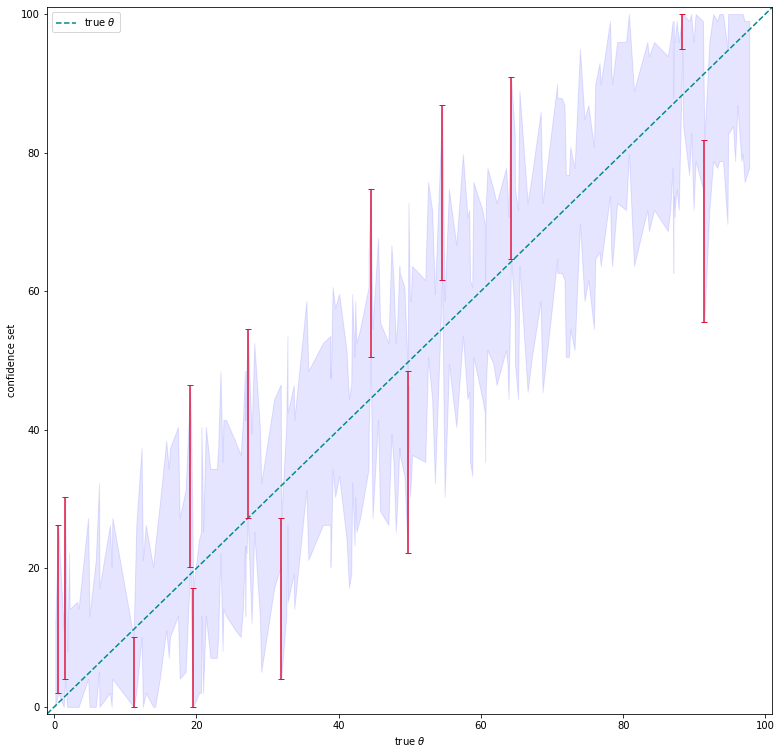

In [11]:
df = acore.plot_confidence_band(return_df=True)

In [12]:
df.loc[df.covered == False,:].shape

(13, 7)

#### Marginals

In [55]:
data = generate_data(sample_size=100000, lower_theta=0, higher_theta=100, scale=5, split=False)
data

,theta,x1,x2
0,91.910903,34.238727,-47.266094
1,64.219560,33.509770,-31.121799
2,75.371223,39.496169,-37.100041
3,13.931457,2.303321,2.127874
4,8.731955,4.056685,-3.361545
...,...,...,...
99995,63.566421,31.276785,-34.101737
99996,69.032605,34.718979,-42.660761
99997,77.559201,39.078012,-40.675152
99998,98.907985,39.842843,-49.783973


/Users/lucamasserano/Desktop/uni/cmu/ada/ada_code/hep-lfi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lucamasserano/Desktop/uni/cmu/ada/ada_code/hep-lfi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'x1 (orange), x2 (blue)')

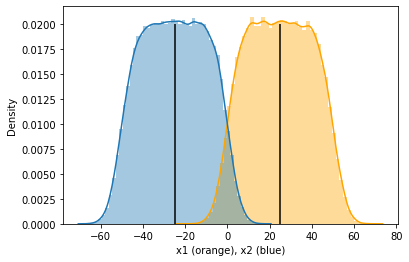

In [61]:
import scipy
sns.distplot(data.x1, color="orange")#, fit=scipy.stats.norm)
plt.vlines(x=[data.x1.mean(), data.x2.mean()], ymin=0, ymax=0.02)
sns.distplot(data.x2)#, fit=scipy.stats.norm)
plt.xlabel("x1 (orange), x2 (blue)")

#### Likelihood of single x

In [24]:
# sample separation parameter
theta1 = np.repeat(np.random.uniform(low=0, high=100, size=1), 10000)
theta2 = np.repeat(np.random.uniform(low=0, high=100, size=1), 10000)
theta = np.vstack((theta1, theta2))

# sample points symmetrically around 0
x_1 = np.random.normal(loc=theta/2, scale=5)
x_2 = np.random.normal(loc=-theta/2, scale=5)

data = np.hstack((theta.reshape(-1, 1),
                  x_1.reshape(-1, 1),
                  x_2.reshape(-1, 1)))
data

array([[ 72.08433594,  37.78828048, -36.94542906],
       [ 72.08433594,  31.95710752, -41.34848259],
       [ 72.08433594,  29.89342393, -37.34153524],
       ...,
       [ 99.7851811 ,  45.48003201, -49.52726782],
       [ 99.7851811 ,  42.95235866, -55.2915502 ],
       [ 99.7851811 ,  44.65777377, -48.71040618]])

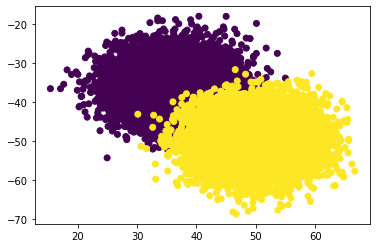

In [25]:
plt.scatter(x=data[:, 1], y=data[:, 2], c=data[:, 0])